In [59]:
import torch
import numpy as np
from matplotlib import pyplot
import os

import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
import matplotlib.pyplot as plt
import pandas as pd
import random 

In [75]:
train = datasets.CIFAR10(root="CIFAR10/processed/training.pt", train = True, download = True)
test  = datasets.CIFAR10(root="CIFAR10/processed/test.pt", train = False, download = True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

len(train), len(test)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

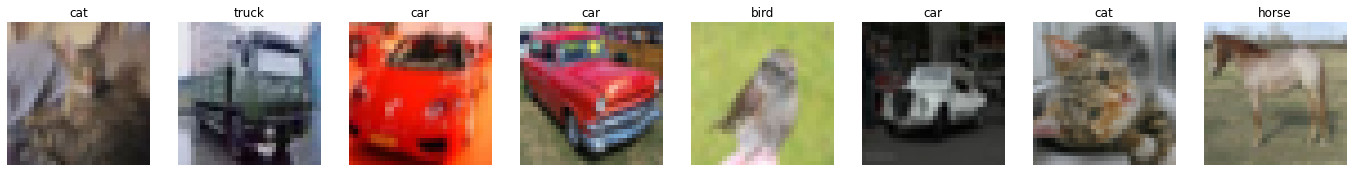

In [74]:
r, c = 1, 8
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(train)-1)
        img, label = train[ix]
        plt.imshow(img)
        plt.axis('off')
        plt.title(classes[label])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [41]:
#procesado de datos
X_train = torch.from_numpy(train.data)
Y_train = torch.from_numpy(np.array(train.targets))

X_test = torch.from_numpy(test.data)
Y_test = torch.from_numpy(np.array(test.targets))

X_train = torch.flatten(X_train, start_dim=1)
X_test = torch.flatten(X_test, start_dim=1)


X_train = (X_train.numpy())/255.
Y_train = Y_train.numpy()

X_test = X_test.numpy()/255
Y_test = Y_test.numpy()

In [ ]:
X_train, X_val, X_test = X[:45000] / 255., X[45000:] / 255. , torch.from_numpy(test.data)
y_train, y_val, y_test = Y[:45000].astype(np.int), Y[45000:].astype(np.int), 

X_train.shape, X_val.shape, X_test.shape

In [43]:
def cross_entropy(output, target):
    #funcion de perdida
    logits = output[torch.arange(len(output)), target]
    loss = - logits + torch.log(torch.sum(torch.exp(output), axis=-1))
    loss = loss.mean()
    return loss

In [44]:
from sklearn.metrics import accuracy_score

def softmax(x):
    """distribucion de probabilidad"""
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def evaluate(x):
    """saca la probabilidad mas alta, para clasificar"""
    model.eval()
    y_pred = model(x)
    y_probas = softmax(y_pred)
    return torch.argmax(y_probas, axis=1)

In [45]:
X_t = torch.from_numpy(X_train).float().cuda()
Y_t = torch.from_numpy(Y_train).long().cuda()

In [46]:
class Model(torch.nn.Module):
    
    # constructor
    def __init__(self, D_in, H1, D_out):
        
        # llamamos al constructor de la clase madre
        super(Model, self).__init__()
        
        # definimos nuestras capas
        self.fc1 = torch.nn.Linear(D_in, H1)
        self.relu = torch.nn.ReLU()      
        self.fc2 = torch.nn.Linear(H1, D_out)
        
    # lógica para calcular las salidas de la red
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [47]:
type(X_t), X_t.dtype

(torch.Tensor, torch.float32)

In [48]:
model = Model(3072, 100, 10)
#outputs = model(torch.randn(64, 3072))
#outputs.shape
model.to("cuda")

Model(
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [49]:
criterion = torch.nn.CrossEntropyLoss()#funcion de perdida
optimizer = torch.optim.SGD(model.parameters(), lr=1)#descenso por el gradiente

epochs = 1500
log_each = 100
l = []
model.train()
y_pred = 0
for e in range(1, epochs+1): 
    
    # forward
    y_pred = model(X_t)

    # loss
    loss = criterion(y_pred, Y_t)
    l.append(loss.item())
    
    # ponemos a cero los gradientes
    optimizer.zero_grad()

    # Backprop (calculamos todos los gradientes automáticamente)
    loss.backward()

    # update de los pesos
    optimizer.step()
    
    if not e % log_each:
        print(f"Epoch {e}/{epochs} Loss {np.mean(l):.3f}")
        
y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(Y_test, y_pred.cpu().numpy())

Epoch 100/1500 Loss 2.949
Epoch 200/1500 Loss 2.629
Epoch 300/1500 Loss 2.521
Epoch 400/1500 Loss 2.466
Epoch 500/1500 Loss 2.433
Epoch 600/1500 Loss 2.411
Epoch 700/1500 Loss 2.396
Epoch 800/1500 Loss 2.384
Epoch 900/1500 Loss 2.375
Epoch 1000/1500 Loss 2.368
Epoch 1100/1500 Loss 2.362
Epoch 1200/1500 Loss 2.357
Epoch 1300/1500 Loss 2.353
Epoch 1400/1500 Loss 2.349
Epoch 1500/1500 Loss 2.346


0.099

2da parte

In [50]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float().cuda()
        self.Y = torch.from_numpy(Y).long().cuda()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]
    
dataset = Dataset(X_train, Y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

In [51]:
def fit(model, dataloader, epochs=500, log_each=100):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1)
    l = []
    model.train()
    for e in range(1, epochs+1): 
        _l = []
        for x_b, y_b in dataloader:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        l.append(np.mean(_l))
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f}")
    return {'epoch': list(range(1, epochs+1)), 'loss': l}

In [52]:
#model = build_model()
hist = fit(model, dataloader)

Epoch 100/500 loss 2.30511
Epoch 200/500 loss 2.30502
Epoch 300/500 loss 2.30530
Epoch 400/500 loss 2.30519
Epoch 500/500 loss 2.30501


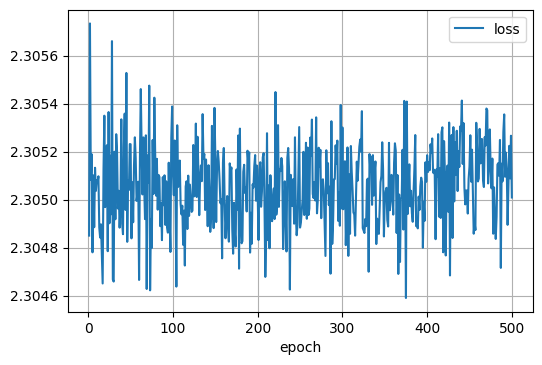

In [53]:
fig = plt.figure(dpi=100)
ax = plt.subplot(111)
pd.DataFrame(hist).plot(x='epoch', grid=True, ax=ax)
plt.show()

In [54]:
y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(Y_test, y_pred.cpu().numpy())

0.1

In [55]:
def fit(model, dataloader, epochs=30, log_each=5):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.8)
    model.train()
    l, acc = [], []
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        for x_b, y_b in dataloader:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f}")
    return {'epoch': list(range(1, epochs+1)), 'loss': l, 'acc': acc}

In [56]:
hist = fit(model, dataloader)

Epoch 5/30 loss 2.30441 acc 0.10122
Epoch 10/30 loss 2.30465 acc 0.09954
Epoch 15/30 loss 2.30440 acc 0.10056
Epoch 20/30 loss 2.30429 acc 0.10336
Epoch 25/30 loss 2.30441 acc 0.09858
Epoch 30/30 loss 2.30437 acc 0.10054


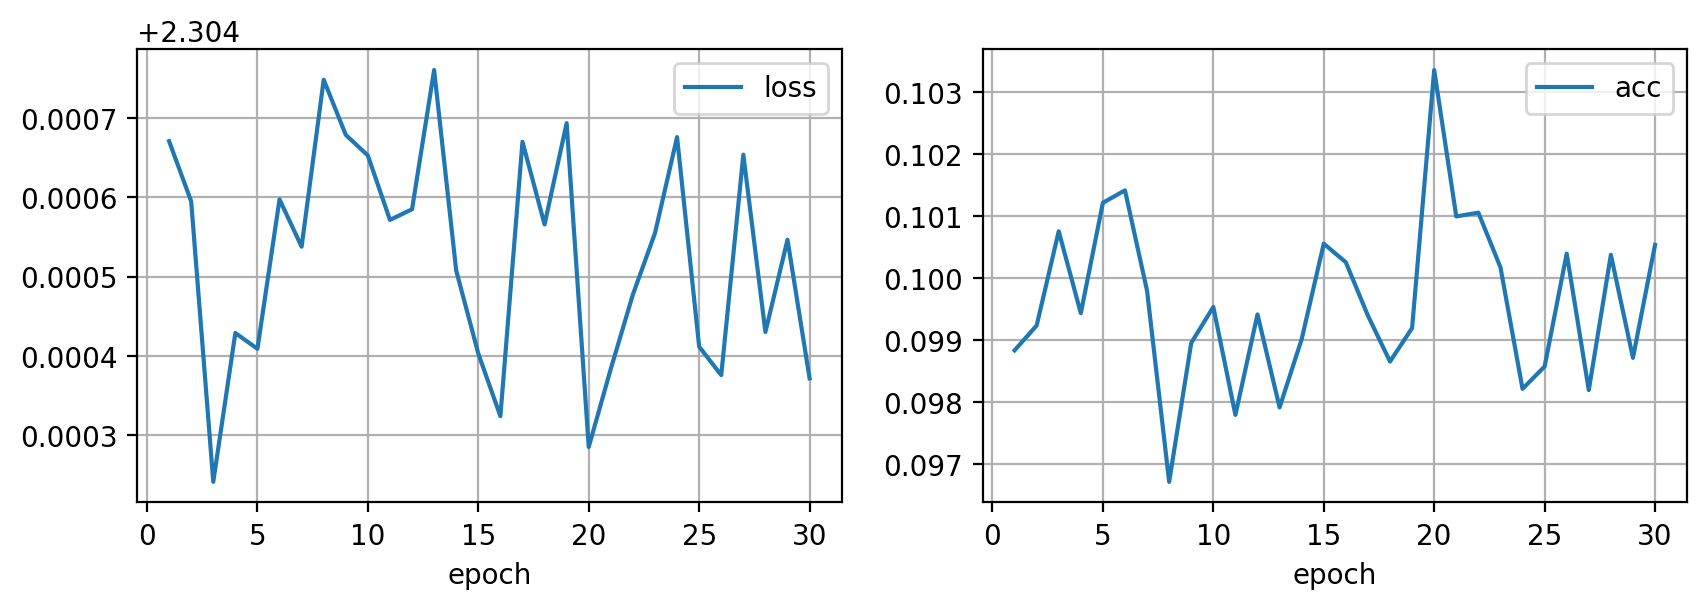

In [57]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y='loss', grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y='acc', grid=True, ax=ax)
plt.show()

In [73]:
y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(Y_test, y_pred.cpu().numpy())

0.1

In [78]:
X_train.shape, X_test.shape

((50000, 3072), (10000, 3072))

In [76]:
X_train, X_val, X_test = X[:45000] / 255., X[45000:] / 255. ,
y_train, y_val, y_test = Y[:50000].astype(np.int), Y[50000:60000].astype(np.int), Y[60000:].astype(np.int)

X_train.shape, X_val.shape, X_test.shape

NameError: ignored